# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

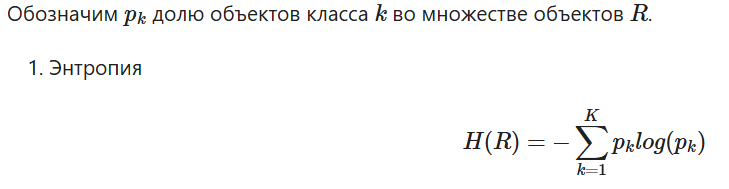

In [2]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
def entropy(k_list):
  all_obj = sum(k_list)
  res = 0
  for k in k_list:
    p_k = k / all_obj
    res -= p_k * np.log(p_k)
  return res

k1 = 2
k2 = 8
print(f"Entropy: {entropy([k1, k2]):.2f}")

Entropy: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

def gini(k_list):
  all_obj = sum(k_list)
  res = 0
  for k in k_list:
    p_k = k / all_obj
    res += p_k * (1 - p_k)
  return res

def cr_of_inf_for_gini(k_l_list, k_r_list, k_m_list):
  return gini(k_m_list) - (sum(k_l_list) / float(sum(k_m_list))) * gini(k_l_list) - (sum(k_r_list) / float(sum(k_m_list))) * gini(k_r_list)

k1 = 2
k2 = 8
print(f"Criterion of informativeness: {cr_of_inf_for_gini([k1, 0], [0, k2], [k1, k2]):.2f}")

Criterion of informativeness: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

# возьмем среднее всех значений
print(np.mean(np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])))

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [2]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def cr_of_inf_for_gini(k_l_list, k_r_list, k_m_list):
  return gini(k_m_list) - (np.sum(k_l_list) / np.sum(k_m_list)) * gini(k_l_list) - (np.sum(k_r_list) / np.sum(k_m_list)) * gini(k_r_list)

def cr_of_inf_for_var(k_l_list, k_r_list, k_m_list):
    return np.var(k_m_list) - (len(k_l_list) / len(k_m_list)) * np.var(k_l_list) - (len(k_r_list) / len(k_m_list)) * np.var(k_r_list)

In [3]:
from collections import Counter

c = Counter(["l", "l", "l", "r"])
c.values()

dict_values([3, 1])

In [8]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух соседних (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)

    # сортируем target
    target_vector = target_vector[np.argsort(feature_vector)]

    # сортируем признаки
    feature_vector = np.sort(feature_vector)

    # проверяем на константность признака
    if feature_vector[0] == feature_vector[-1]:
      return (np.arange(0,1), np.arange(0,1), 0, 0)

    # ну у меня здесь лежат посчитанные критерии информативности
    # мне кажется, условие задание не совсем верно сформулировано
    ginis = [] # ну у меня здесь лежат посчитанные критерии информативности, мне кажется, условие задание не совсем верно сформулировано

    if feature_type == "real": # признак числовой
      thresholds = (feature_vector[1:] + feature_vector[:-1]) / 2

      for threshold in thresholds:
        left_leaf_feature = target_vector[feature_vector <= threshold]
        right_leaf_feature = target_vector[feature_vector > threshold]

        counter_left = Counter(left_leaf_feature)
        counter_right = Counter(right_leaf_feature)
        counter_target = Counter(target_vector)

        # считаем gini в таком случае
        if task == "classification":
          ginis.append(cr_of_inf_for_gini(
              np.array(list(counter_left.values())),
              np.array(list(counter_right.values())),
              np.array(list(counter_target.values()))
          ))
        else:
          # в таком случае считаем дисперсию
          ginis.append(cr_of_inf_for_var(
              left_leaf_feature,
              right_leaf_feature,
              target_vector
          ))
    else: # признак категориальный
      thresholds  = np.unique(feature_vector)

      for threshold in thresholds:
        left_leaf_feature = target_vector[feature_vector == threshold]
        right_leaf_feature = target_vector[feature_vector != threshold]

        counter_left = Counter(left_leaf_feature)
        counter_right = Counter(right_leaf_feature)
        counter_target = Counter(target_vector)

        # считаем gini в таком случае
        if task == "classification":
          ginis.append(cr_of_inf_for_gini(
              np.array(list(counter_left.values())),
              np.array(list(counter_right.values())),
              np.array(list(counter_target.values()))
          ))
        else:
          # в таком случае считаем дисперсию
          ginis.append(cr_of_inf_for_var(
              left_leaf_feature,
              right_leaf_feature,
              target_vector
          ))

    arg_best = np.argmax(ginis)

    return thresholds, np.array(ginis), thresholds[arg_best], ginis[arg_best]

Эту функцию можно протестировать на датасете `California`.

In [4]:
from sklearn.datasets import fetch_california_housing

In [11]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


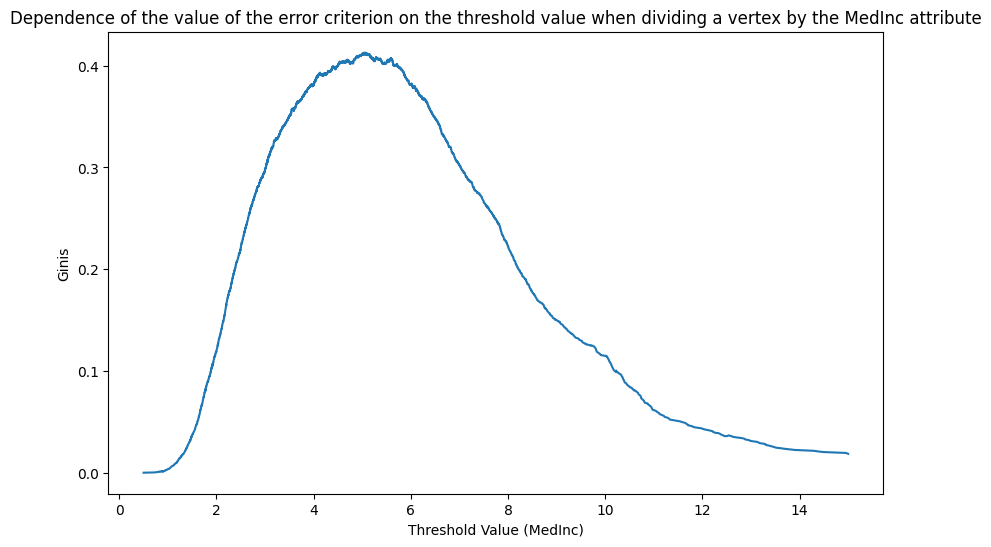

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

feature_vector = X['MedInc'].values
target_vector = y

thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, target_vector, "regression", "real")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, ginis)
plt.title('Dependence of the value of the error criterion on the threshold value when dividing a vertex by the MedInc attribute')
plt.xlabel('Threshold Value (MedInc)')
plt.ylabel('Ginis')
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [12]:
for column in X.columns:
  print(column)

MedInc
HouseAge
AveRooms
AveBedrms
Population
AveOccup
Latitude
Longitude


In [13]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

gini_best_all = -float('inf')
best_feature = ""

for column in X.columns:
  feature_vector = X[column].values
  target_vector = y

  thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector, target_vector, "regression", "real")

  if gini_best_all < gini_best:
    gini_best_all = gini_best
    best_feature = column

print(gini_best_all, best_feature)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.15920795258922488 AveRooms


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (feature_vector <= threshold)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # обновляем важность признаков!!
        self._feature_importances[feature_best] = self._feature_importances.get(feature_best, 0) + gini_best * len(sub_y)

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
        if node["type"] == "terminal":
          # возвращаем класс большинства
          return node["class"]

        feature_best = node["feature_split"]
        x_splitting = x[feature_best]
        if self._feature_types[feature_best] == "real":
            threshold_best = node["threshold"]
            if x_splitting <= threshold_best:
              # вызываем правый
              return self._predict_node(x, node["left_child"])
            else:
              return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_best] == "categorical":
            threshold_best = node["category_split"]
            if x_splitting == threshold_best:
              # вызываем правый
              return self._predict_node(x, node["left_child"])
            else:
              return self._predict_node(x, node["right_child"])
        else:
            raise ValueError

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

    # для просмотра важности признаков
    def feature_importances_(self) -> np.ndarray:
      if not hasattr(self, '_feature_importances'):
          raise ValueError("Дерево еще не обучено")

      sum_imp = float(sum(self._feature_importances.values()))
      for key in self._feature_importances.keys():
        self._feature_importances[key] /= sum_imp
      return self._feature_importances

    # метод для восстановления пропущенных значений
    def _update_missing_values(self, X: np.ndarray) -> np.ndarray:
      X_update = X.copy()
      for feature in range(X.shape[1]):
          feature_type = self._feature_types[feature]
          feature_vector = X[:, feature]

          missing_mask = np.isnan(feature_vector)

          if np.any(missing_mask):
              if feature_type == "real":
                  # заменяем на медиану, если это числовой признак
                  median = np.nanmedian(feature_vector)
                  X_update[missing_mask, feature] = median
              elif feature_type == "categorical":
                  # заменяем на моду, если это категориальный признак
                  values, counts = np.unique(feature_vector[~missing_mask], return_counts=True)
                  mode = values[np.argmax(counts)]
                  X_update[missing_mask, feature] = mode
      return X_update

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
df = pd.read_csv('students.csv')
df = df.drop('Unnamed: 0', axis=1)

df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [ ]:
df.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS'], dtype='object')

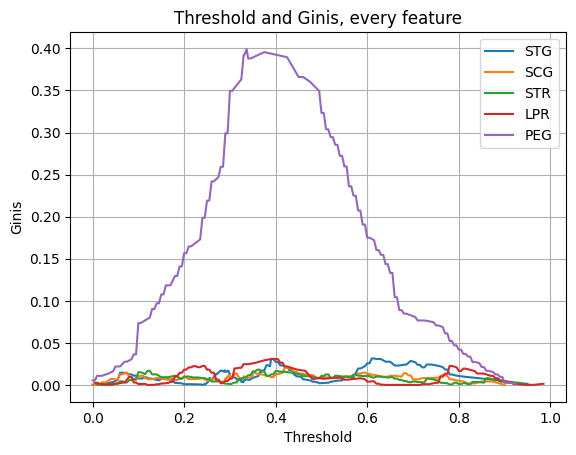

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

features = df.columns[:-1]
target = df.columns[-1]

for feature in features:
  thresholds, ginis, threshold_best, gini_best = find_best_split(df[feature].values, df[target].values, task="classification", feature_type="real")

  plt.plot(thresholds, ginis, label=feature)

plt.title('Threshold and Ginis, every feature')
plt.xlabel('Threshold')
plt.ylabel('Ginis')
plt.legend()
plt.grid(True)
plt.show()

Очевидно, что больше всего подходит признак PEG, так как он показывает самые высокие результаты относительно критерия информативности.

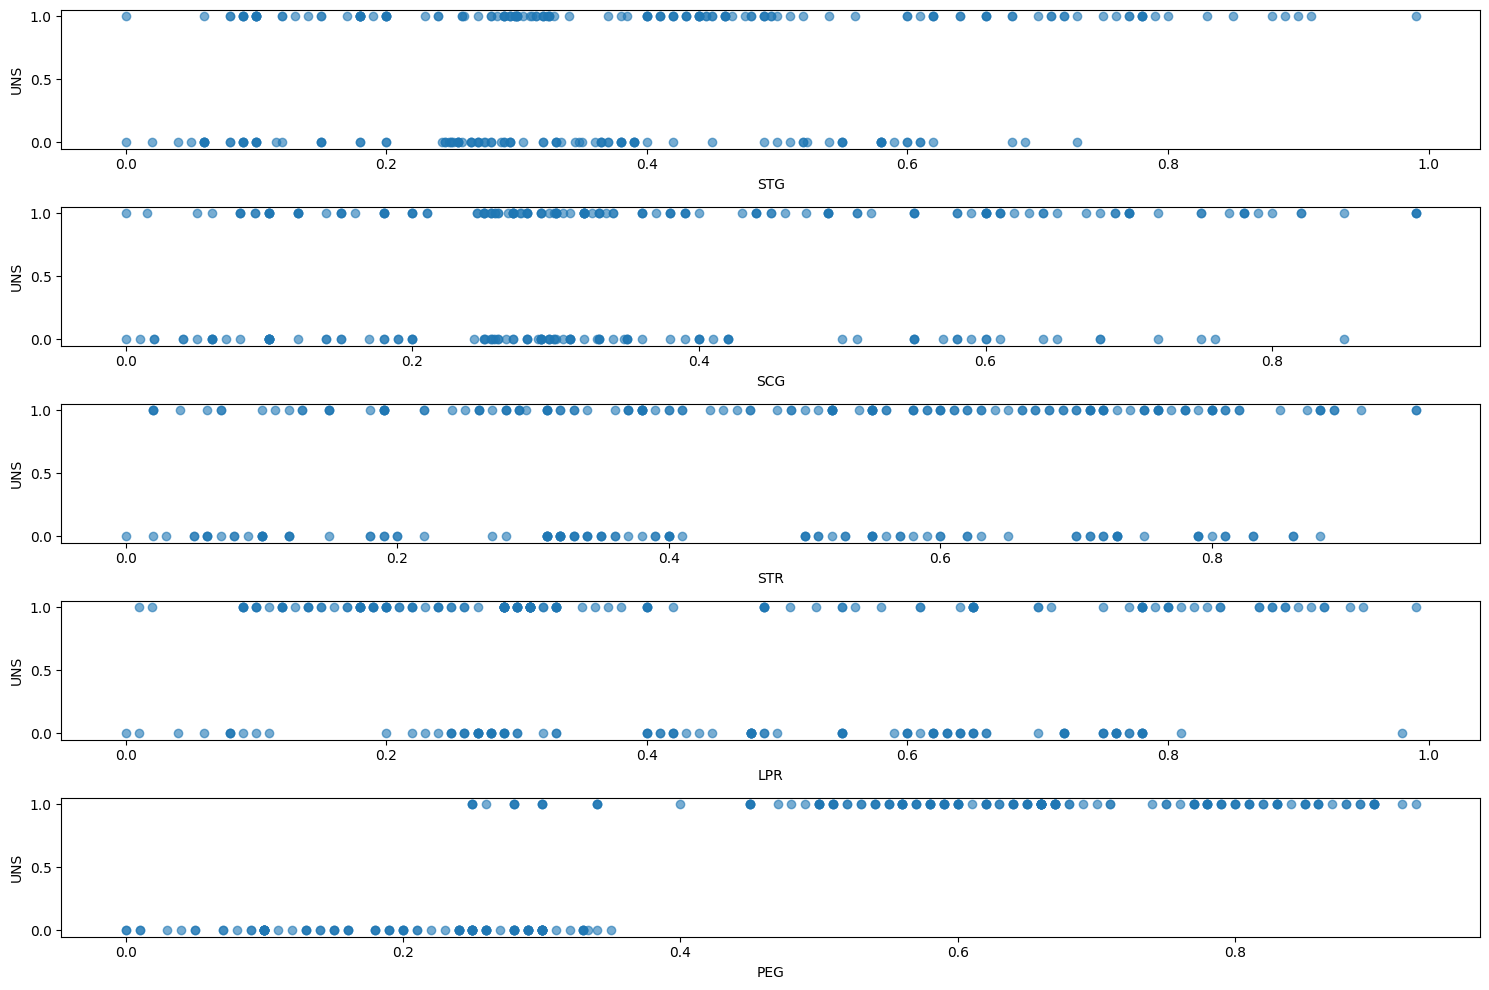

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 10))

for plt_num, feature in enumerate(features):
  axes[plt_num].scatter(df[feature], df[target], alpha=0.6)
  axes[plt_num].set_xlabel(feature)
  axes[plt_num].set_ylabel(target)

plt.tight_layout()
plt.show()

В том числе это можно лицезреть по диаграммам рассеянности. Мы можем заметить, как четко разделяет лучший порог у PFG (примерно 0.33, совсем немного ошибок в предсказаниях), и как плохо это происходит на других признаках



**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
le = LabelEncoder()
for column in df.columns:
  df[column] = le.fit_transform(df[column])

df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [ ]:
y = df[0]
X = df.drop(0, axis=1)
X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=45)

tree = DecisionTree(feature_types=["categorical"]*(X_train.shape[1]))

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(tree.feature_importances_())

1.0
{4: np.float64(0.6342292111491921), 19: np.float64(0.03398537269936652), 12: np.float64(0.009131878398165288), 7: np.float64(0.006469342399393129), 0: np.float64(0.0009819935684169322), 1: np.float64(0.0009831387504209582), 3: np.float64(0.04033931577357246), 10: np.float64(0.24776514339911027), 6: np.float64(0.0261146038623622)}


УРААААААААААААААААААААААААААААААААААААААА. окак, четыре роляет

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [6]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [8]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

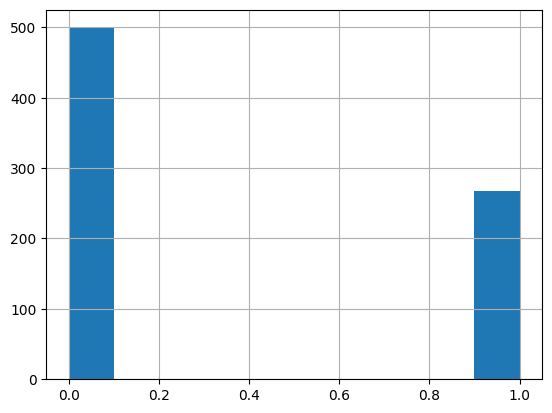

In [9]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [10]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=234)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=347)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [15]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

max_depth_params = [None, 1, 2, 4, 8, 16, 32, 40, 48, 56, 64, 78, 85, 93, 100]
min_samples_leaf_params = [1, 2, 4, 8, 16, 28, 32, 40, 48, 56, 64, 78, 85, 93, 100]

best_params = ()
best_f1_score = -1

for max_depth in max_depth_params:
  for min_samples in min_samples_leaf_params:
    decision_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples)
    decision_tree.fit(X_train_train, y_train_train)
    y_pred = decision_tree.predict(X_train_val)
    f1_curr = f1_score(y_train_val, y_pred)
    if f1_curr > best_f1_score:
      best_f1_score = f1_curr
      best_params = (max_depth, min_samples)

print(f"Наилучшие результаты при max_depth={best_params[0]} и min_samples={best_params[1]}, где best_f1_score={best_f1_score}")

decision_tree = DecisionTreeClassifier(max_depth=best_params[0], min_samples_split=best_params[1])
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print("Итоговые метрики с подобранными гиперпараметрами на полной обучающей выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Auc_roc: {roc_auc_score(y_test, y_pred)}")

Наилучшие результаты при max_depth=None и min_samples=8, где best_f1_score=0.6434782608695652
Итоговые метрики с подобранными гиперпараметрами на полной обучающей выборке:
Accuracy: 0.7489177489177489
Precision : 0.6419753086419753
Recall: 0.6419753086419753
Auc_roc: 0.724320987654321


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [16]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

bagging_cl = BaggingClassifier(n_estimators=50)
bagging_cl.fit(X_train, y_train)
y_pred = bagging_cl.predict(X_test)

print("Итоговые метрики с подобранными гиперпараметрами на полной обучающей выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Auc_roc: {roc_auc_score(y_test, y_pred)}")

Итоговые метрики с подобранными гиперпараметрами на полной обучающей выборке:
Accuracy: 0.7575757575757576
Precision : 0.6666666666666666
Recall: 0.6172839506172839
Auc_roc: 0.7253086419753088


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [20]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————
max_depth_params = [None, 1, 2, 4, 8, 16, 32, 40, 48, 56, 64, 78, 85, 93, 100]
min_samples_split_params = [2, 4, 8, 16, 28, 32, 40, 48, 56, 64, 78, 85, 93, 100]

f1_scorer = make_scorer(f1_score)

parameters = {'max_depth':max_depth_params, 'min_samples_split':min_samples_split_params}
rfc = RandomForestClassifier(n_estimators=50)
gs_cv = GridSearchCV(estimator=rfc, param_grid=parameters, scoring=f1_scorer, cv=4, verbose=3)

gs_cv.fit(X_train, y_train)

print(f"Лучшие параметры: {gs_cv.best_params_}")
print(f"Лучший результат f1_score: {gs_cv.best_score_:.4f}")

Fitting 4 folds for each of 210 candidates, totalling 840 fits
[CV 1/4] END max_depth=None, min_samples_split=2;, score=0.652 total time=   0.1s
[CV 2/4] END max_depth=None, min_samples_split=2;, score=0.524 total time=   0.1s
[CV 3/4] END max_depth=None, min_samples_split=2;, score=0.571 total time=   0.1s
[CV 4/4] END max_depth=None, min_samples_split=2;, score=0.759 total time=   0.1s
[CV 1/4] END max_depth=None, min_samples_split=4;, score=0.667 total time=   0.1s
[CV 2/4] END max_depth=None, min_samples_split=4;, score=0.571 total time=   0.1s
[CV 3/4] END max_depth=None, min_samples_split=4;, score=0.629 total time=   0.1s
[CV 4/4] END max_depth=None, min_samples_split=4;, score=0.716 total time=   0.1s
[CV 1/4] END max_depth=None, min_samples_split=8;, score=0.667 total time=   0.1s
[CV 2/4] END max_depth=None, min_samples_split=8;, score=0.543 total time=   0.1s
[CV 3/4] END max_depth=None, min_samples_split=8;, score=0.614 total time=   0.1s
[CV 4/4] END max_depth=None, min_sa

In [24]:
best_rf = RandomForestClassifier(n_estimators=50, **gs_cv.best_params_, random_state=45)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Итоговые метрики с подобранными гиперпараметрами на полной обучающей выборке:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision : {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Auc_roc: {roc_auc_score(y_test, y_proba)}")

Итоговые метрики с подобранными гиперпараметрами на полной обучающей выборке:
Accuracy: 0.7792207792207793
Precision : 0.6973684210526315
Recall: 0.654320987654321
Auc_roc: 0.8253497942386832


Из всех построенных моделей лучше всего показала себя по всем метрикам третья (случайный лес с подобранными параметрами). Вот метрики каждой модели:

Первая модель:
Accuracy: 0.7489177489177489
Precision : 0.6419753086419753
Recall: 0.6419753086419753
Auc_roc: 0.724320987654321

Вторая модель:
Accuracy: 0.7575757575757576
Precision : 0.6666666666666666
Recall: 0.6172839506172839
Auc_roc: 0.7253086419753088

Третья модель:
Accuracy: 0.7792207792207793
Precision : 0.6973684210526315
Recall: 0.654320987654321
Auc_roc: 0.8253497942386832

Особенно как мне кажется, стоит смотреть в нашем случае на recall, так как мы хотим предсказать наличие диабета у пациента, а в таком случае нам критичен пропуск положительных случаев.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

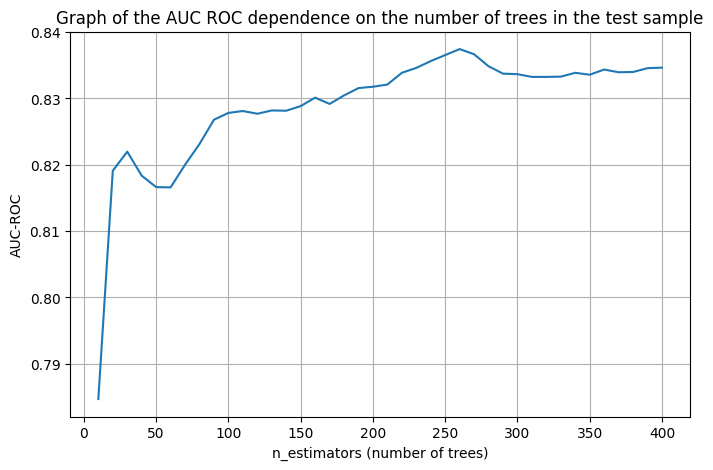

In [31]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

n_estimators_params = [i for i in range(10, 401, 10)]

auc_roc_res = []

best_model = None
best_auc = 0

for n_estimators in n_estimators_params:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=52)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    auc_roc_res.append(score)

    if score > best_auc:
      best_auc = score
      best_model = rf

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_params, auc_roc_res)
plt.grid(True)
plt.title('Graph of the AUC ROC dependence on the number of trees in the test sample')
plt.xlabel('n_estimators (number of trees)')
plt.ylabel('AUC-ROC')
plt.show()

График показывает, что добавление деревьев улучшает качество модели лишь до определенного предела, при этом переобучения с увелечением деревьев не случается. Оптимальное значение при n_estimators=260

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [32]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 260,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 52,
 'verbose': 0,
 'warm_start': False}

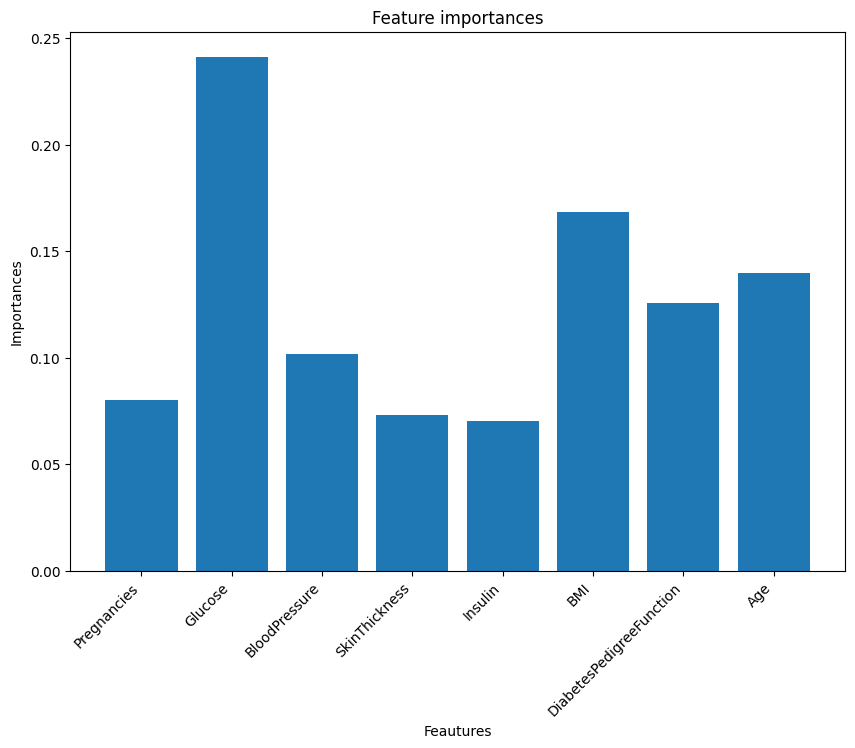

In [36]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

plt.figure(figsize=(10, 7))
plt.title("Feature importances")
plt.bar(X.columns, best_model.feature_importances_);
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feautures')
plt.ylabel('Importances')
plt.show()

Самый важным признаком оказался уровень глюкозы в крови, что в целом логично